In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forecast as fc
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [58]:
# Neural network for Forecasting data
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=100, #100        best with 100
  decay_rate=1, #1              best with 1
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=200, min_delta=0.0001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[
                  tf.keras.losses.MeanAbsoluteError("auto", "mean_absolute_error"),
                  'accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=1000,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            verbose=2)

    return history

In [59]:
INPUTDIM = (28,40)
OUTPUTDIM = (28,7)

#Training data set

input_train=np.load('../data/input_train.npy')
input_test=np.load('../data/input_test.npy')
output_train=np.load('../data/output_train.npy')
output_test=np.load('../data/output_test.npy')

In [60]:
input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')

# x = layers.LSTM(32, return_sequences=True, name = 'blstm1')(input_layer)

# x_encoder = layers.Bidirectional(layers.LSTM(32), name = 'blstm2')(input_layer)

# input_dec = tf.expand_dims(tf.ones((INPUTDIM[0],1)),0)

# x = layers.LSTM(OUTPUTDIM[1], return_sequences=True, name = 'lstm', activation=None)(input_dec, initial_state=x_encoder)

x = layers.Dense(64, activation='elu',kernel_regularizer = regularizers.l2(0.00)) (input_layer)

x = layers.SimpleRNN(64, activation='elu',kernel_regularizer = regularizers.l2(0.00), return_sequences=True) (x)

x = layers.Dense(OUTPUTDIM[1], activation='elu',kernel_regularizer = regularizers.l2(0.00))(x)

model = tf.keras.Model(inputs=input_layer, outputs = x, name ='model')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 40)]          0         
                                                                 
 dense_16 (Dense)            (None, 28, 64)            2624      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 28, 64)            8256      
                                                                 
 dense_17 (Dense)            (None, 28, 7)             455       
                                                                 
Total params: 11,335
Trainable params: 11,335
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=["mean_absolute_error"]
            )

In [62]:
history = model.fit(
            input_train, output_train,
            epochs=1000,
            validation_data=(input_test, output_test),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=50, min_delta=0.0001, restore_best_weights=True, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mean_absolute_error', patience=5, mode='auto', verbose=1, factor=0.01, min_lr=1e-12)
                ]
            )

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 207368.5781 - mean_absolute_error: 99.7947 - val_loss: 109671.1328 - val_mean_absolute_error: 111.8661 - lr: 1.0000e-04
Epoch 2/1000
1/1 [==============================] - 0s 49ms/step - loss: 199089.2188 - mean_absolute_error: 98.0285 - val_loss: 105312.2656 - val_mean_absolute_error: 109.8503 - lr: 1.0000e-04
Epoch 3/1000
1/1 [==============================] - 0s 51ms/step - loss: 191042.4844 - mean_absolute_error: 96.2808 - val_loss: 101099.5391 - val_mean_absolute_error: 107.8625 - lr: 1.0000e-04
Epoch 4/1000
1/1 [==============================] - 0s 68ms/step - loss: 183223.0156 - mean_absolute_error: 94.5502 - val_loss: 97000.8906 - val_mean_absolute_error: 105.8870 - lr: 1.0000e-04
Epoch 5/1000
1/1 [==============================] - 0s 102ms/step - loss: 175634.9531 - mean_absolute_error: 92.8374 - val_loss: 93021.2422 - val_mean_absolute_error: 103.9281 - lr: 1.0000e-04
Epoch 6/1000
1/1 [====================

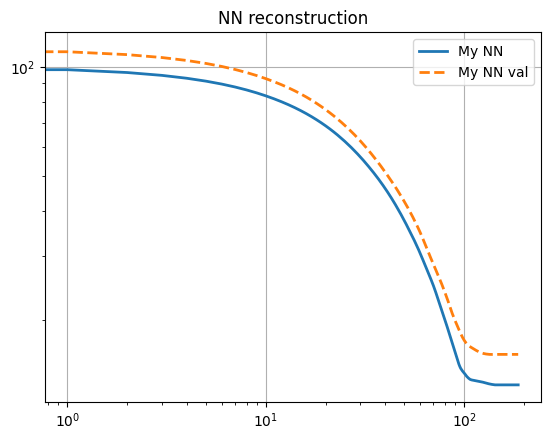

In [63]:
bc     = history.history['mean_absolute_error']
val_bc = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN reconstruction')
plt.grid(True)
#plt.show(block=False)

plt.legend(('My NN','My NN val'))
plt.show()

In [64]:
import pickle

# Load the dictionary from the file
with open('..\data\provinces_fit.pickle', 'rb') as file:
    provinces_fitted = pickle.load(file)

1/1 [==============================] - 0s 353ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_18060\3796577518.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rec_output.shape[0],1, tw+1)


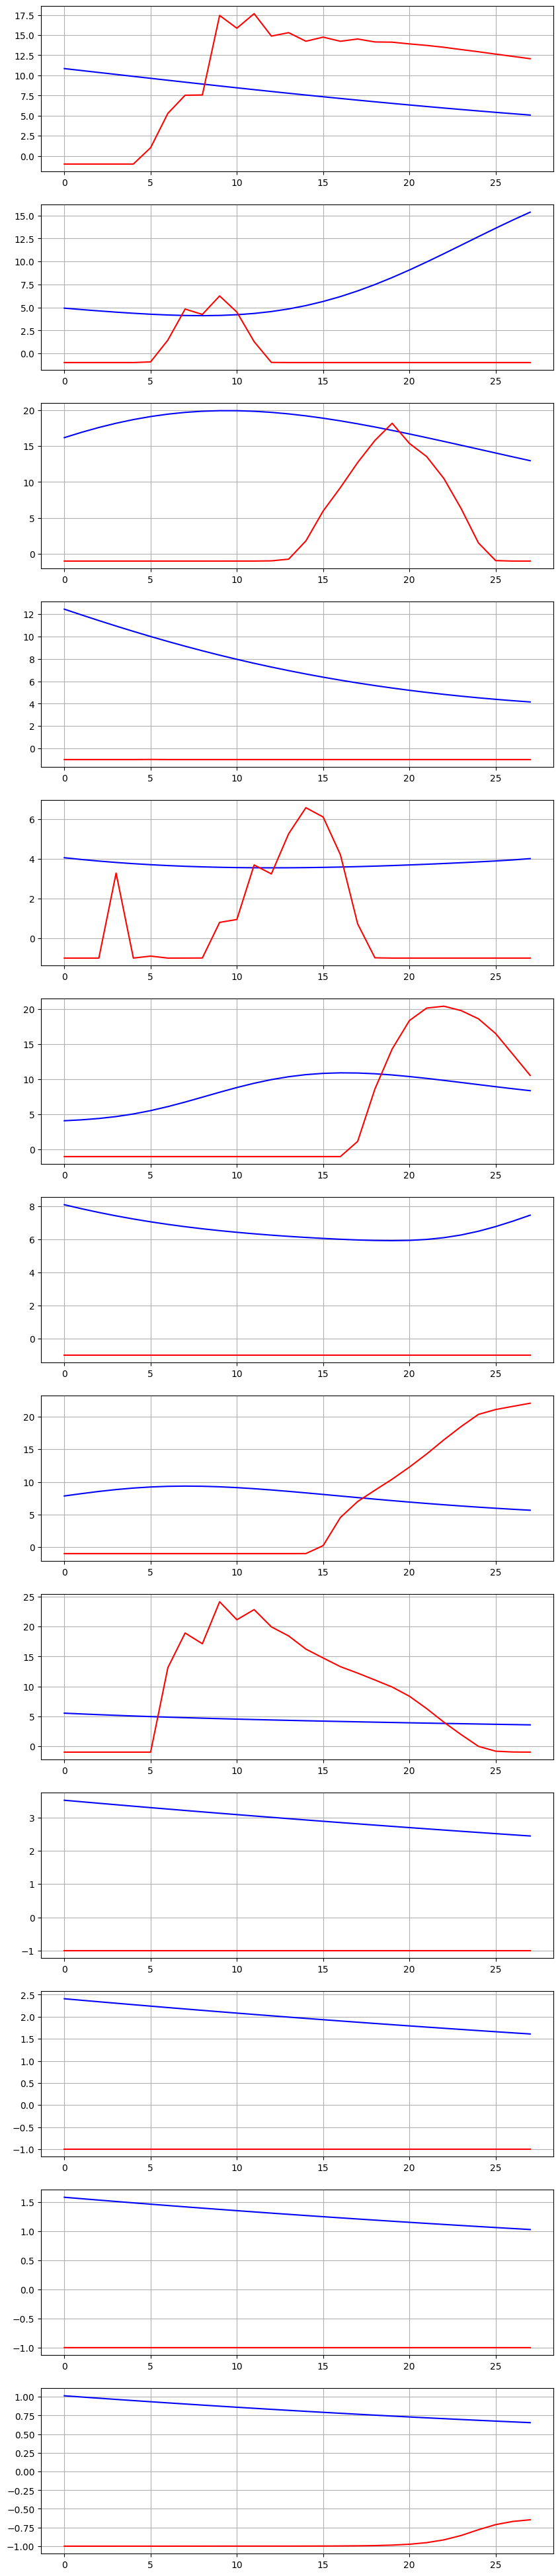

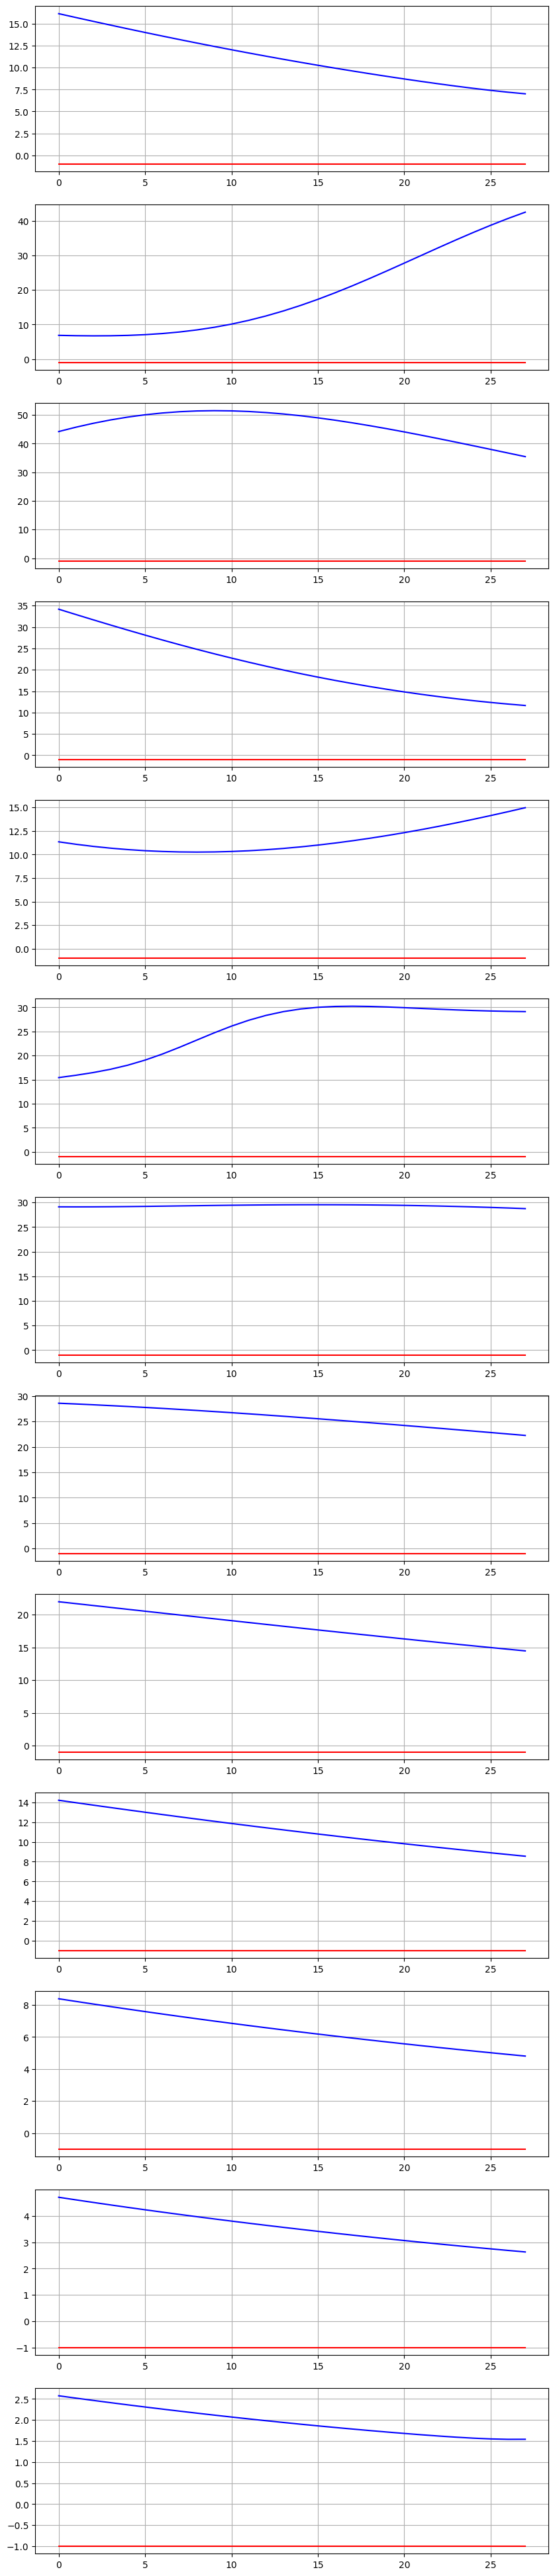

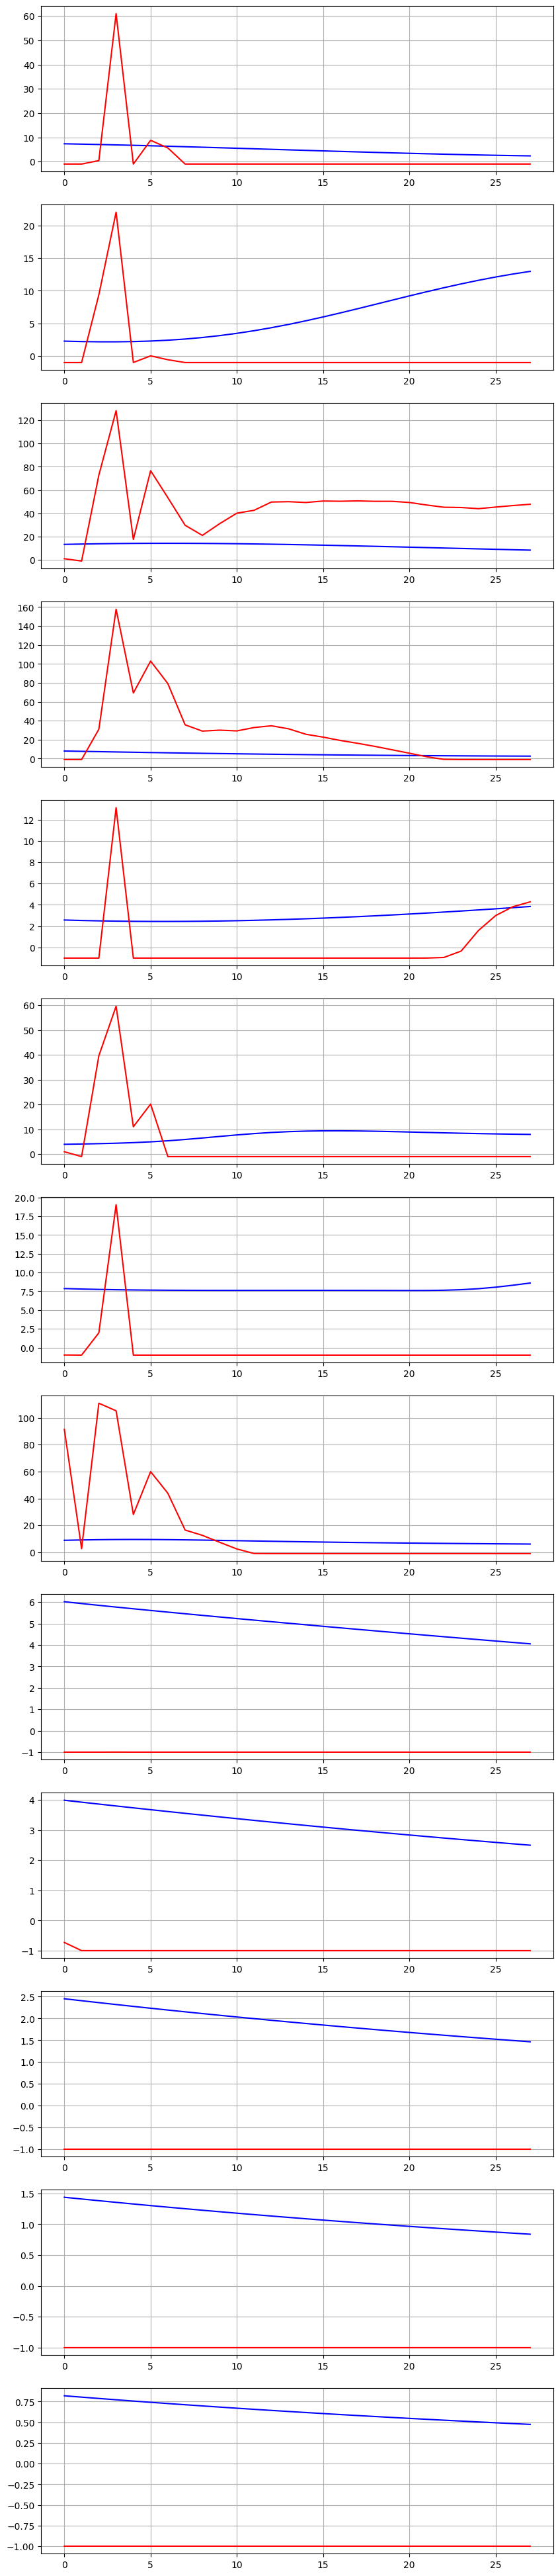

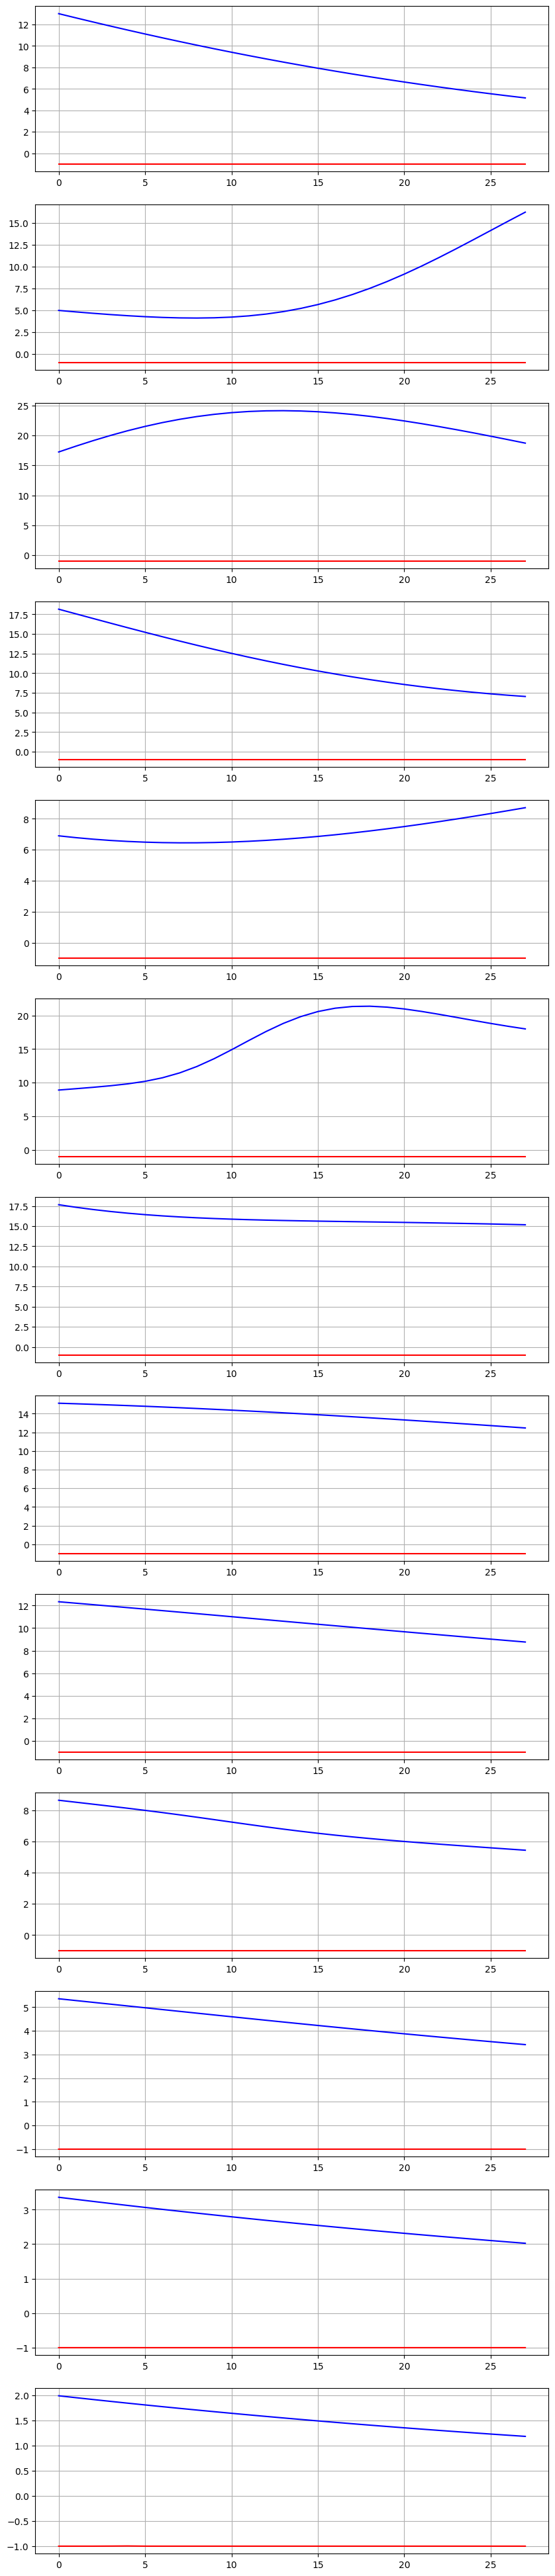

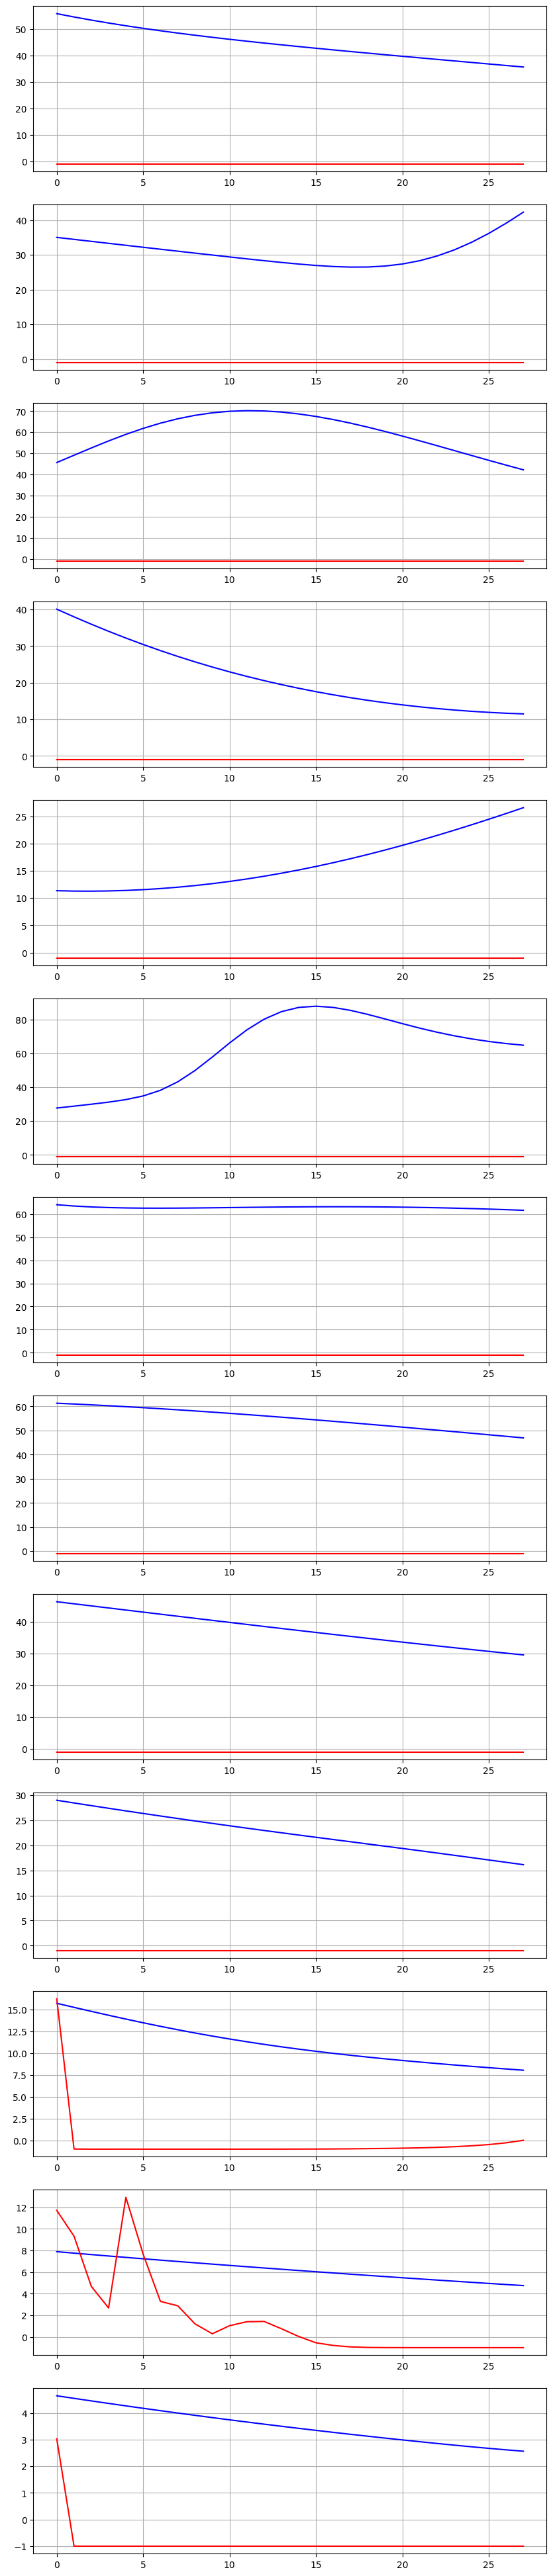

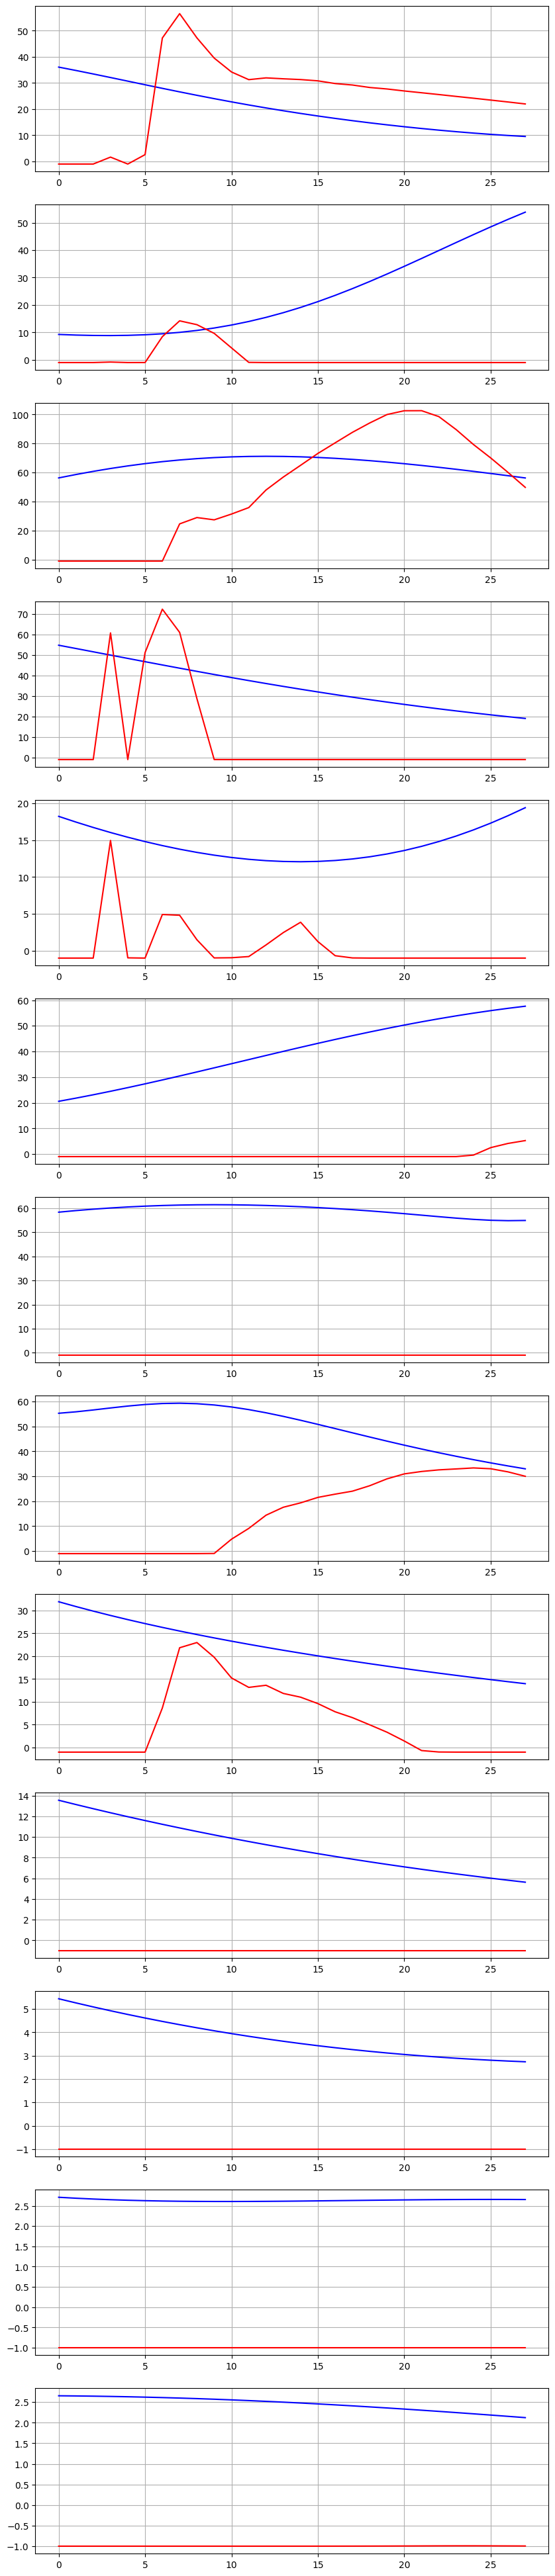

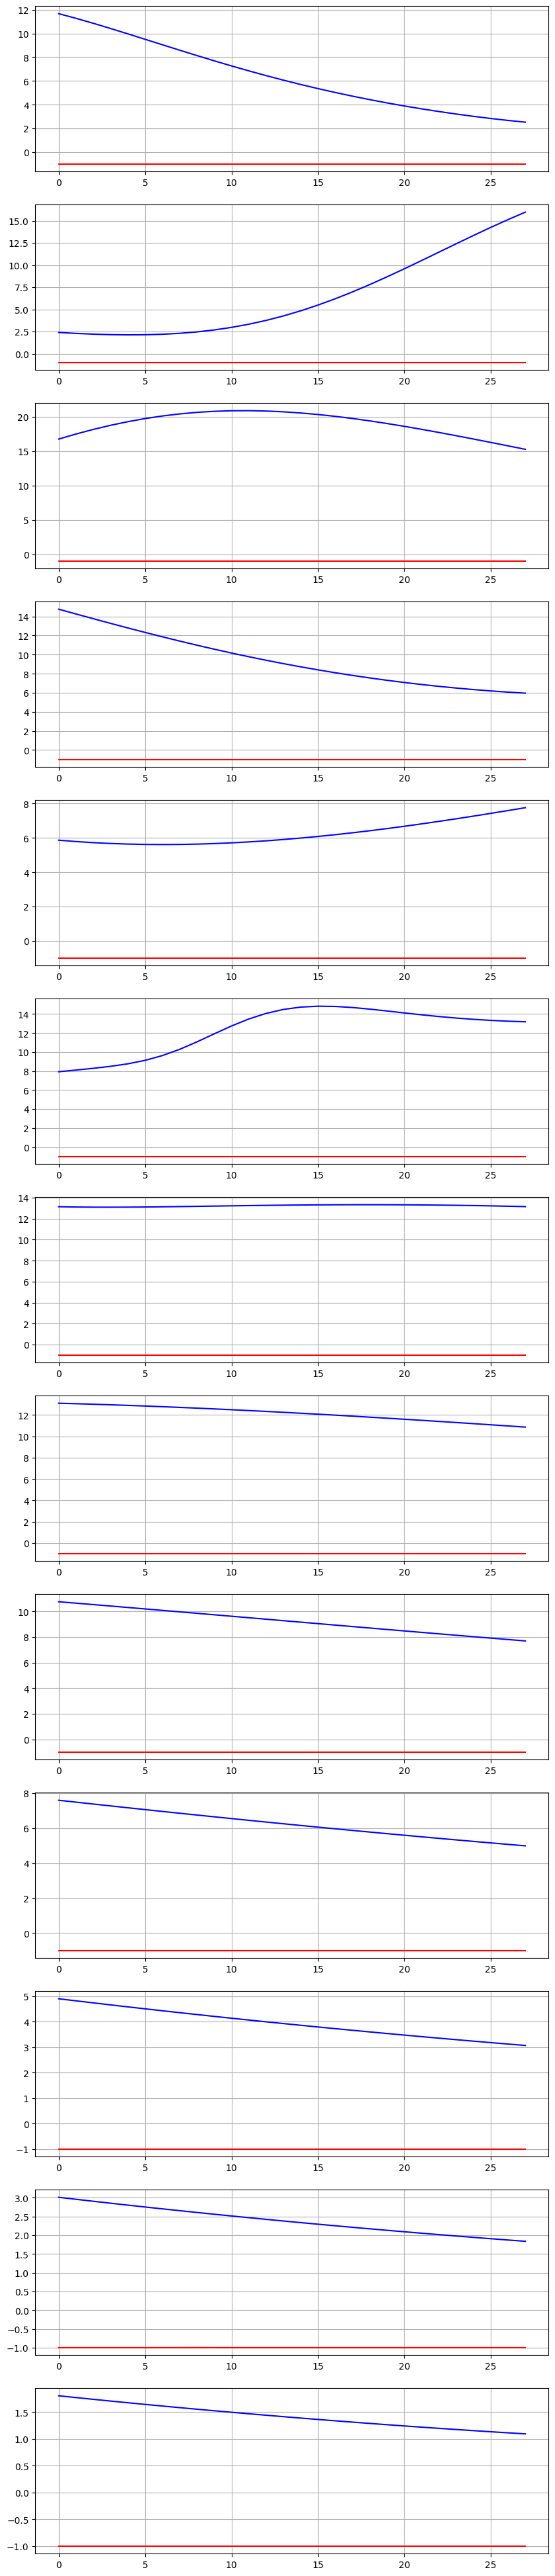

In [65]:
rec_output = model.predict(input_test)
for prov in range(rec_output.shape[2]):
    plt.figure(figsize=(10,50))
    plt.title(list(provinces_fitted.keys())[prov])
    for tw in range(rec_output.shape[0]):
        plt.subplot(rec_output.shape[0],1, tw+1)
        plt.plot(output_test[tw,:,prov], color='blue')
        plt.plot(rec_output[tw,:,prov], color='red')
        plt.grid(True)

1/1 [==============================] - 0s 38ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_18060\2432805453.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rec_output.shape[0],1, tw+1)


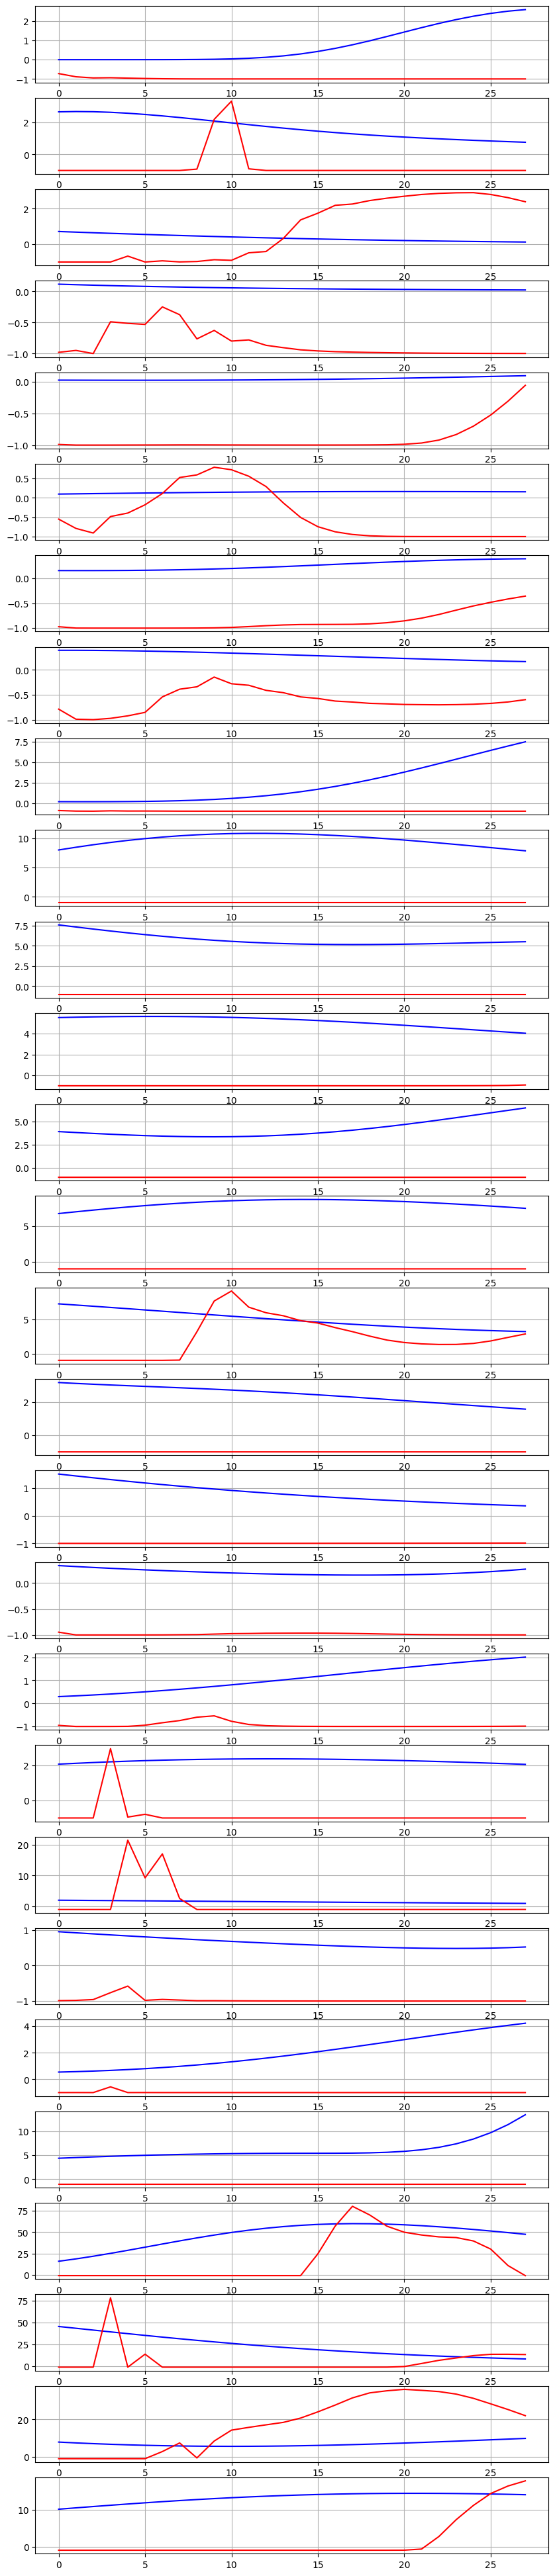

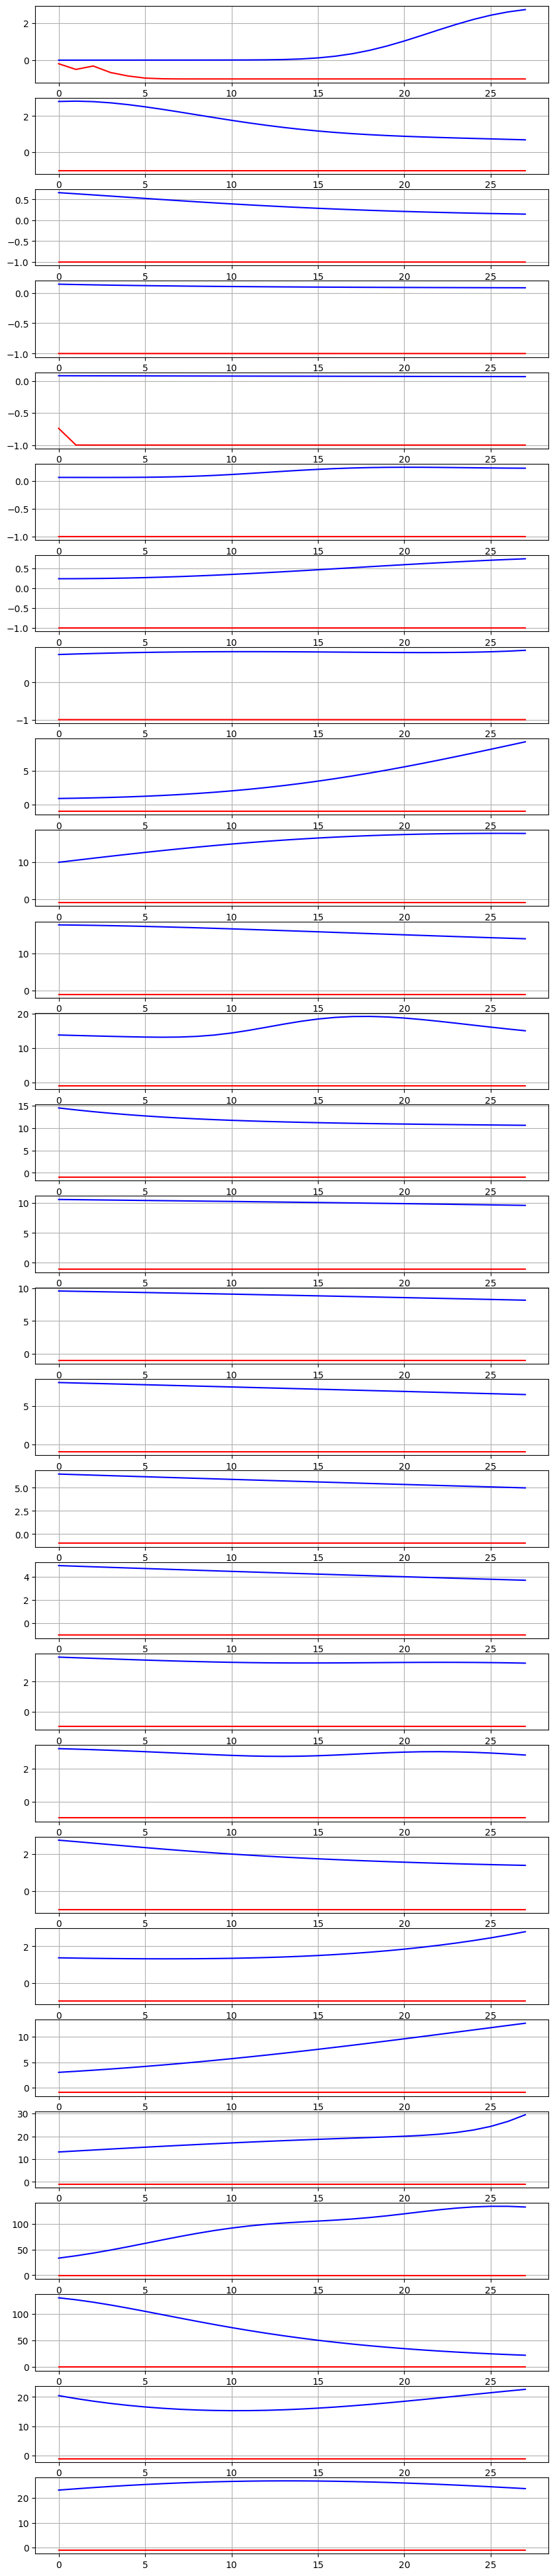

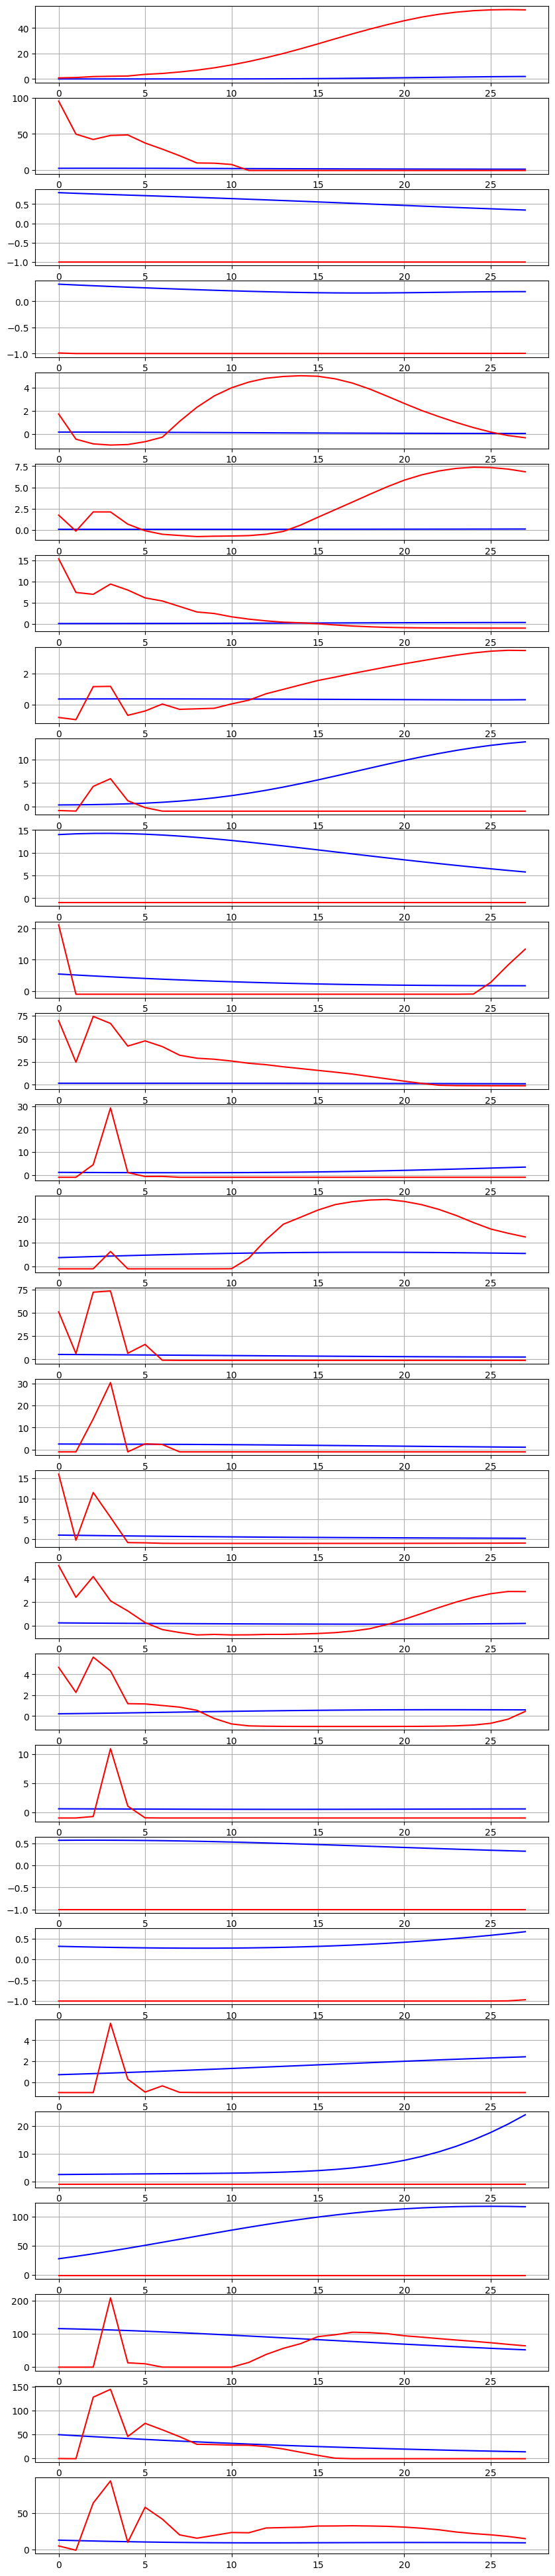

In [66]:
rec_output = model.predict(input_train)
for prov in range(3):
    plt.figure(figsize=(10,50))
    plt.title(list(provinces_fitted.keys())[prov])
    for tw in range(rec_output.shape[0]):
        plt.subplot(rec_output.shape[0],1, tw+1)
        plt.plot(output_train[tw,:,prov], color='blue')
        plt.plot(rec_output[tw,:,prov], color='red')
        plt.grid(True)